<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/15_3_dataset_for_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00


## 15.3 The Dataset for Pretraining Word Embeddings

In [2]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l

### 15.3.1 Reading the Dataset

In [6]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
  """Load the PTB dataset into a list of text lines."""
  data_dir = d2l.download_extract('ptb')
  with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
    raw_text = f.read()
  return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [7]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

### 15.3.2 Subsampling

In [9]:
def subsample(sentences, vocab):
  """Subsample high-frequency words."""
  # Exclude unknown tokens ('<unk>')
  sentences = [[token for token in line if vocab[token] != vocab.unk]
               for line in sentences]
  counter = collections.Counter([
      token for line in sentences for token in line])
  num_tokens = sum(counter.values())

  # Return True if 'token' is kept during subsampling
  def keep(token):
    return (random.uniform(0, 1) <
            math.sqrt(1e-4 / counter[token] * num_tokens))

  return ([[token for token in line if keep(token)] for line in sentences],
          counter)

subsampled, counter = subsample(sentences, vocab)

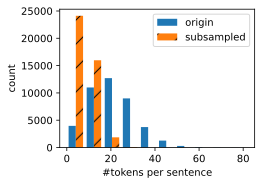

In [10]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '#tokens per sentence',
                            'count', sentences, subsampled);

In [11]:
def compare_counts(token):
  return (f'# of "{token}": '
          f'before={sum([l.count(token) for l in sentences])}, '
          f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2043'

In [12]:
compare_counts('join')

'# of "join": before=45, after=45'

In [13]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [6697, 3228], [3922, 1922, 4743]]

### 15.3.3 Extracting Center Words and Context Words

In [14]:
def get_centers_and_contexts(corpus, max_window_size):
  """Return center words and context words in skip-gram."""
  centers, contexts = [], []
  for line in corpus:
    # To form a "center word--context word" pair, each sentence needs to have at leat two words
    if len(line) < 2:
      continue
    centers +=line
    for i in range(len(line)): # Context window centered at 'i'
      window_size = random.randint(1, max_window_size)
      indices = list(range(max(0, i - window_size),
                           min(len(line), i + 1 + window_size)))
      # Exclude the center word from the context words
      indices.remove(i)
      contexts.append([line[idx] for idx in indices])
  return centers, contexts

In [15]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
  print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


In [16]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1500804'